# Cycling Network Analysis – Graz

Course: GIS Analysis Techniques 2  
Group: 1  
Authors: Fleischhacker, Y.;  Galitschitsch, M.;  Koschu, K.;  Lambert, D.​


In [62]:
import sys

import osmnx as ox
import geopandas as gpd
import networkx as nx
import pandas as pd
from keplergl import KeplerGl
import numpy as np
import sys
import matplotlib.pyplot as plt
import warnings
from shapely.geometry import LineString, Polygon, MultiPolygon
from scipy.interpolate import RectBivariateSpline
import json
from shapely.geometry import Point 
from shapely.geometry import box, Point
from pathlib import Path
import rasterio
from rasterio.merge import merge
from rasterio.mask import mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
import gc, time
import subprocess
import os

print(sys.executable) #environment sanity check



c:\Users\kosch\anaconda3\envs\geo\python.exe


# Data preparation 

In [2]:
## Study Area ##
place = "Graz, Austria"
main_crs = "EPSG:31256"

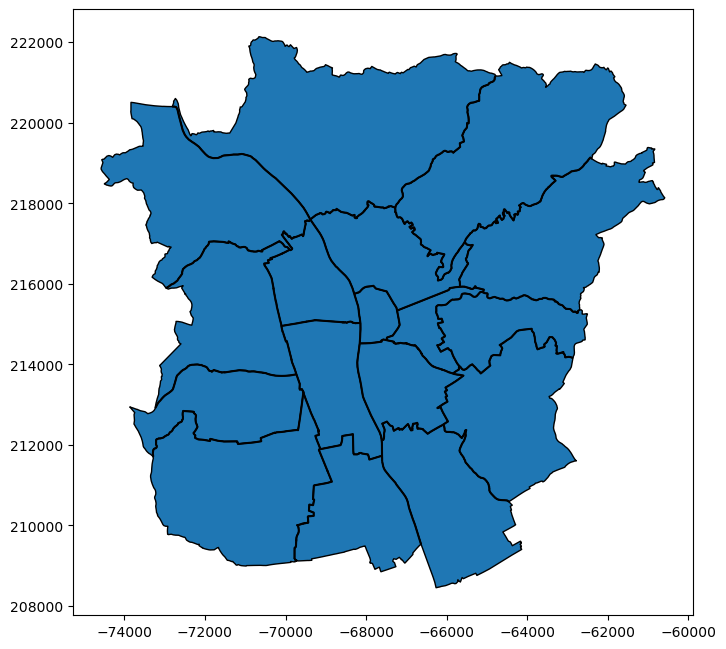

In [3]:
## city and districts ##
gdf_boundaries = ox.features_from_place(
    place,
    tags={"boundary": "administrative"}
)

df_districts = gdf_boundaries[gdf_boundaries["admin_level"] == "9"]
df_districts = df_districts.to_crs(main_crs)

df_districts.plot(edgecolor="black", figsize=(8, 8))
plt.show()

In [5]:
## main universities ##
name_map = {
    "Universitätsplatz 3, 8010 Graz": "KF Uni Graz",
    "Rechbauerstraße 12, 8010 Graz": "TU Graz",
    "Neue Stiftingtalstraße 6, 8010 Graz": "Med Uni Graz",
    "Leonhardstraße 15, 8010 Graz": "KUG",
    "Körblergasse 126, 8010 Graz": "Campus02",
    "Alte Poststraße 149, 8010 Graz": "FH Joanneum",
    "Hasnerplatz 12, 8010 Graz": "PHSt",
    "Inffeldgasse 25, 8010 Graz": "TU Graz/ Campus Inffeld",
}

poi = list(name_map.keys())

#Geocoding
coords = [ox.geocode(addr) for addr in poi]
uni_points = [Point(lon, lat) for lat, lon in coords]

#GeoDataFrame
graz_unis = gpd.GeoDataFrame(
    {"name": poi},
    geometry=uni_points,
    crs="EPSG:4326"
).to_crs(main_crs)
graz_unis["short_name"] = graz_unis["name"].map(name_map).fillna(graz_unis["name"])

In [16]:
## bike network (g_core) ##
G_raw = ox.graph_from_place(
    place,
    network_type="bike",
    simplify=True,
    retain_all=True
)
G_raw = ox.project_graph(G_raw, to_crs=main_crs)

nodes_gdf, edges_gdf = ox.graph_to_gdfs(G_raw, nodes=True, edges=True)

def _to_str(x):
    return ",".join(map(str, x)) if isinstance(x, list) else str(x)

edges_gdf["highway_str"] = edges_gdf["highway"].apply(_to_str)

is_service = edges_gdf["highway_str"].str.contains("service", na=False)

is_driveway = pd.Series(False, index=edges_gdf.index)
if "service" in edges_gdf.columns:
    svc_str = edges_gdf["service"].apply(_to_str)
    is_driveway |= svc_str.isin(["driveway", "parking_aisle"])

is_forbidden = pd.Series(False, index=edges_gdf.index)
if "access" in edges_gdf.columns:
    is_forbidden |= edges_gdf["access"].isin(["private", "no"])
if "bicycle" in edges_gdf.columns:
    is_forbidden |= edges_gdf["bicycle"].isin(["no"])

service_bad = is_service & (is_driveway | is_forbidden)
non_service = ~is_service

touch_non_service = pd.Series(False, index=pd.Index(list(G_raw.nodes), dtype=object))
for (u, v, k), is_ns in non_service.items():
    if is_ns:
        touch_non_service.at[u] = True
        touch_non_service.at[v] = True

drop = pd.Series(False, index=edges_gdf.index)
for (u, v, k) in edges_gdf.index[service_bad]:
    if (not touch_non_service.get(u, False)) and (not touch_non_service.get(v, False)):
        drop.at[(u, v, k)] = True

edges_keep = edges_gdf.loc[~drop].copy()

nodes_keep = set(edges_keep.index.get_level_values(0)).union(
    set(edges_keep.index.get_level_values(1))
)
nodes_keep_gdf = nodes_gdf.loc[list(nodes_keep)].copy()

G_bike = ox.graph_from_gdfs(nodes_keep_gdf, edges_keep)

largest_wcc_nodes = max(nx.weakly_connected_components(G_bike), key=len)
G_core = G_bike.subgraph(largest_wcc_nodes).copy()


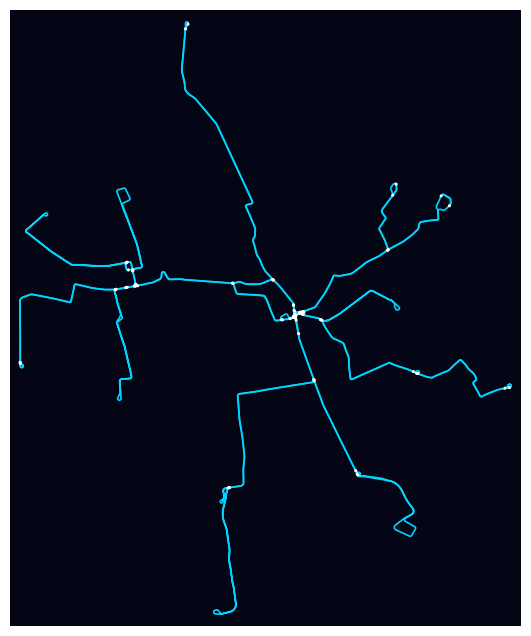

In [ ]:
## Tram network ##
def get_tram_network(place: str, main_crs: str):
    tram_filter = (
        '["railway"="tram"]'
        '["service"!="yard"]'
        '["service"!="siding"]'
        '["service"!="spur"]'
    )

    tram = ox.graph_from_place(
        place,
        custom_filter=tram_filter,
        simplify=True,
        retain_all=True
    )

    tram = ox.project_graph(tram, to_crs=main_crs)

    largest_wcc_nodes = max(nx.weakly_connected_components(tram), key=len)
    tram_main = tram.subgraph(largest_wcc_nodes).copy()

    nodes_gdf, edges_gdf = ox.graph_to_gdfs(tram_main, nodes=True, edges=True)

    if "length" not in edges_gdf.columns:
        edges_gdf["length"] = edges_gdf.geometry.length
    else:
        edges_gdf["length"] = edges_gdf["length"].fillna(edges_gdf.geometry.length)

    keep_cols = ["geometry", "length", "name", "service", "railway"]
    keep_cols = [c for c in keep_cols if c in edges_gdf.columns]
    tram_lines = gpd.GeoDataFrame(edges_gdf[keep_cols].copy(), geometry="geometry", crs=nodes_gdf.crs)

    return tram_main, tram_lines

tram_main, tram_lines = get_tram_network(place, main_crs)

#Plot
fig, ax = ox.plot_graph(
    tram_main,
    node_size=5,
    bgcolor="#040615",
    edge_color="#00d4ff",
    edge_linewidth=1.2
)


# Preprocessing

In [ ]:
## DEM ##
#path = Path(r"C:\Users\kosch\Desktop\final-project-group1-cycling-network\data_dem")

#raw_dirs = [path / s for s in ("352x20x","352x21x","353x20x","353x21x","354x20x","354x21x")]

#tiff = sorted({p for d in raw_dirs if d.exists() for p in d.rglob("*.tif")})

#city_geom = df_districts.to_crs(main_crs).dissolve().geometry.iloc[0]

# fixing
#fixed_dir = path / "_fixed_tiles"
#fixed_dir.mkdir(exist_ok=True)

#FIX_NODATA = -9999.0
#fixed_tifs = []
#for p in tiff:
#    out_p = fixed_dir / f"{p.parent.name}__{p.name}"
#
#    if not out_p.exists():
#        with rasterio.open(p) as src:
#            data = src.read(1).astype("float32")
#            data[data < -1e20] = FIX_NODATA

#            meta = src.meta.copy()
#            meta.update(dtype="float32", nodata=FIX_NODATA, count=1)

#        with rasterio.open(out_p, "w", **meta) as dst:
#            dst.write(data, 1)

#    fixed_tifs.append(out_p)

# mosaic
#srcs = [rasterio.open(p) for p in fixed_tifs]
#try:
#    mosaic, mosaic_transform = merge(srcs, nodata=FIX_NODATA, dtype="float32")
#    meta = srcs[0].meta.copy()
#finally:
#    for s in srcs:
#        s.close()

#meta.update(
#    height=mosaic.shape[1],
#    width=mosaic.shape[2],
#    transform=mosaic_transform,
#    dtype="float32",
#    nodata=FIX_NODATA,
#    count=mosaic.shape[0],
#)

# crs
#dst_transform, dst_width, dst_height = calculate_default_transform(
#    meta["crs"], main_crs, meta["width"], meta["height"],
#    *rasterio.transform.array_bounds(meta["height"], meta["width"], meta["transform"])
#)

#reproj = np.empty((meta["count"], dst_height, dst_width), dtype="float32")
#for i in range(meta["count"]):
#    reproject(
#        source=mosaic[i],
#        destination=reproj[i],
#        src_transform=meta["transform"],
#        src_crs=meta["crs"],
#        dst_transform=dst_transform,
#        dst_crs=main_crs,
#        resampling=Resampling.bilinear,
#        src_nodata=FIX_NODATA,
#        dst_nodata=FIX_NODATA,
#    )

#reproj_meta = meta.copy()
#reproj_meta.update(crs=main_crs, transform=dst_transform, width=dst_width, height=dst_height)

# clip and save
#with rasterio.io.MemoryFile() as mf:
#    with mf.open(**reproj_meta) as ds:
#        ds.write(reproj)

#        out_img, out_transform = mask(ds, [city_geom], crop=True, nodata=FIX_NODATA)

#        out_meta = ds.meta.copy()
#        out_meta.update(height=out_img.shape[1], width=out_img.shape[2], transform=out_transform, nodata=FIX_NODATA)

#final_path = Path("..") / "data" / "processed" / "dem_graz.tif"
#with rasterio.open(final_path, "w", **out_meta) as dst:
#    dst.write(out_img)

In [ ]:
## Calculation slope ##
dem_path = Path("..") / "data" / "processed" / "dem_graz.tif"
slope_path = Path("..") / "data" / "processed" / "slope_graz.tif"

result = subprocess.run([
        "gdaldem", "slope", str(dem_path), str(slope_path),
        "-s", "1",                 
        "-compute_edges",             
        "-of", "GTiff",               
        "-co", "COMPRESS=LZW",        
        "-co", "TILED=YES"           
    ], 
    capture_output=True, 
    text=True, 
    timeout=300
    )

In [19]:
## Snapping ##
graz_unis_proj = graz_unis.to_crs(main_crs).copy()

if "short_name" not in graz_unis_proj.columns:
    graz_unis_proj["short_name"] = graz_unis_proj["name"]

nodes, node_dists = ox.distance.nearest_nodes(
    G_core,
    X=graz_unis_proj.geometry.x.to_numpy(),
    Y=graz_unis_proj.geometry.y.to_numpy(),
    return_dist=True
)
graz_unis_proj["core_node"] = nodes
graz_unis_proj["snap_dist_m"] = node_dists

edges, edge_dists = ox.distance.nearest_edges(
    G_core,
    X=graz_unis_proj.geometry.x.to_numpy(),
    Y=graz_unis_proj.geometry.y.to_numpy(),
    return_dist=True
)
graz_unis_proj["core_edge"] = edges
graz_unis_proj["snap_edge_dist_m"] = edge_dists

print(graz_unis_proj[["short_name", "name", "core_node", "snap_dist_m"]].sort_values("snap_dist_m", ascending=False))


                short_name                                 name    core_node  \
7  TU Graz/ Campus Inffeld           Inffeldgasse 25, 8010 Graz  12459216275   
4                 Campus02          Körblergasse 126, 8010 Graz   1359825555   
2             Med Uni Graz  Neue Stiftingtalstraße 6, 8010 Graz    266012637   
0              KF Uni Graz       Universitätsplatz 3, 8010 Graz   3871900100   
3                      KUG         Leonhardstraße 15, 8010 Graz   1120599503   
6                     PHSt            Hasnerplatz 12, 8010 Graz    773222019   
1                  TU Graz        Rechbauerstraße 12, 8010 Graz   4113732444   
5              FH Joanneum       Alte Poststraße 149, 8010 Graz  13384518939   

   snap_dist_m  
7   106.992237  
4    96.615832  
2    57.639884  
0    55.232284  
3    44.373593  
6    44.120209  
1    28.696822  
5    13.708686  


# Analysis

In [ ]:
warnings.filterwarnings("ignore")

print("=" * 60)
print("SETUP: Pre-computing distance maps for all routing analyses (NEW)")
print("=" * 60)

if "core_node" not in graz_unis_proj.columns:
    raise ValueError("graz_unis_proj must contain column 'core_node' (snapped node ids on G_core).")

if tram_lines.crs is None:
    raise ValueError("tram_lines has no CRS. Ensure tram_lines is projected to main_crs.")
if str(tram_lines.crs) != str(main_crs):
    tram_lines = tram_lines.to_crs(main_crs)

# Ensure edge length exists (meters). If missing, compute from geometry length.
edges_tmp = ox.graph_to_gdfs(G_core, nodes=False, edges=True)
if "length" not in edges_tmp.columns:
    print("No 'length' attribute found on edges -> computing from geometry length.")
    for u, v, k, data in G_core.edges(keys=True, data=True):
        geom = data.get("geometry", None)
        if geom is None:
            x1, y1 = G_core.nodes[u]["x"], G_core.nodes[u]["y"]
            x2, y2 = G_core.nodes[v]["x"], G_core.nodes[v]["y"]
            geom = LineString([(x1, y1), (x2, y2)])
            data["geometry"] = geom
        data["length"] = float(geom.length)

# 1) District polygons

valid_districts = []
for _, district in df_districts.iterrows():
    geom = district.geometry
    if isinstance(geom, (Polygon, MultiPolygon)):
        valid_districts.append(district)

print(f"\nProcessing {len(valid_districts)} valid district polygons")

# University nodes 
all_uni_node_ids = graz_unis_proj["core_node"].dropna().tolist()
print(f"Total universities (snapped): {len(all_uni_node_ids)}\n")

# Load slope raster
print("Loading slope data...")
PROJECT_ROOT = Path.cwd().parent 
slope_path = PROJECT_ROOT / "data" / "processed" / "slope_graz.tif"
use_slope = True

with rasterio.open(slope_path) as src:
    slope_data = src.read(1)
    slope_transform = src.transform
    slope_nodata = src.nodata

print(f"  Loaded slope raster: {slope_data.shape}, nodata={slope_nodata}")

def sample_slope_pct(x, y):
    """Sample slope (%) at (x,y) in projected CRS using nearest raster cell."""
    try:
        row, col = rasterio.transform.rowcol(slope_transform, x, y)
        if 0 <= row < slope_data.shape[0] and 0 <= col < slope_data.shape[1]:
            val = float(slope_data[row, col])
            if (slope_nodata is not None and val == slope_nodata) or np.isnan(val):
                return 0.0
            return val
        return 0.0
    except Exception:
        return 0.0

# Tram proximity (spatial)
print("Preparing tram spatial index...")
tram_sindex = tram_lines.sindex

TRAM_DIST_M = 15.0 

def edge_tram_distance_m(edge_geom):
    """Return min distance (m) from edge geometry to nearest tram line."""
    if edge_geom is None:
        return float("inf")

    minx, miny, maxx, maxy = edge_geom.bounds
    bbox = (minx - TRAM_DIST_M, miny - TRAM_DIST_M, maxx + TRAM_DIST_M, maxy + TRAM_DIST_M)

    cand_idx = list(tram_sindex.intersection(bbox))
    if not cand_idx:
        return float("inf")

    cands = tram_lines.geometry.iloc[cand_idx]
    return float(cands.distance(edge_geom).min())

print("Tram index ready.")

# Speed-limit proxy + weighted cost
BIKE_KMH = 15.0  # average cycling speed for time estimation (tune: 12–18)

def get_speed_limit_kmh(edge_data):
    """Get car speed limit proxy (km/h) from OSM maxspeed or highway defaults."""
    if "maxspeed" in edge_data:
        try:
            speed_str = edge_data["maxspeed"]
            if isinstance(speed_str, list):
                speed_str = speed_str[0]
            s = str(speed_str).lower()
            # keep digits only if mixed strings (e.g., "30", "30 km/h")
            if "km" in s:
                s = s.split("km")[0]
            s = "".join(ch for ch in s if (ch.isdigit() or ch == "."))
            if s.strip() != "":
                return float(s)
        except Exception:
            pass

    highway_type = edge_data.get("highway", "residential")
    if isinstance(highway_type, list):
        highway_type = highway_type[0]

    default_limits = {
        "motorway": 120, "trunk": 100, "primary": 80, "secondary": 60,
        "tertiary": 50, "residential": 30, "living_street": 20,
        "pedestrian": 10, "path": 15, "cycleway": 25, "track": 20,
    }
    return float(default_limits.get(highway_type, 30))

def speed_risk_penalty(speed_limit_kmh):
    """
    Penalty for riding next to faster motor traffic.
    No penalty up to 30 km/h, then increasing smoothly.
    """
    if speed_limit_kmh <= 30:
        return 1.0
    # Quadratic growth keeps it gentle but meaningful
    return 1.0 + ((speed_limit_kmh - 30.0) / 50.0) ** 2

def slope_penalty_factor(slope_pct):
    """Penalty for steepness (absolute slope)."""
    return 1.0 + (abs(slope_pct) / 100.0) ** 2

def compute_weighted_cost_seconds(length_m, speed_limit_kmh, has_tramway, slope_pct):
    """
    Weighted generalized cost = bike travel time (seconds) * penalties.
    Output unit: seconds (penalized bike travel time).
    """
    # Base bike travel time (seconds) using constant bike speed
    bike_time_s = length_m / (BIKE_KMH / 3.6)

    # Penalties (dimensionless multipliers)
    risk = speed_risk_penalty(speed_limit_kmh)
    tram = 1.2 if has_tramway else 1.0
    slope = slope_penalty_factor(slope_pct)

    return float(bike_time_s * risk * tram * slope)

# Add weights to ALL edges in G_core (MultiDiGraph safe)
print("\nAdding weighted costs to G_core edges...")

edge_count = 0
tram_true = 0

for u, v, k, data in G_core.edges(keys=True, data=True):
    length_m = float(data.get("length", 100.0))

    geom = data.get("geometry", None)
    if geom is None:
        x1, y1 = G_core.nodes[u]["x"], G_core.nodes[u]["y"]
        x2, y2 = G_core.nodes[v]["x"], G_core.nodes[v]["y"]
        geom = LineString([(x1, y1), (x2, y2)])
        data["geometry"] = geom

    # speed limit proxy (NOT bike speed)
    speed_limit_kmh = get_speed_limit_kmh(data)

    # slope at midpoint
    if use_slope:
        midpt = geom.interpolate(0.5, normalized=True)
        slope_pct = sample_slope_pct(midpt.x, midpt.y)
    else:
        slope_pct = 0.0

    # tram proximity
    tram_dist = edge_tram_distance_m(geom)
    has_tram = tram_dist <= TRAM_DIST_M
    if has_tram:
        tram_true += 1

    # weighted cost in seconds (penalized bike travel time)
    weighted_cost_s = compute_weighted_cost_seconds(length_m, speed_limit_kmh, has_tram, slope_pct)

    # store attributes
    data["weighted_cost"] = float(weighted_cost_s)  # seconds
    data["bike_speed_kmh"] = float(BIKE_KMH)
    data["speed_limit_kmh"] = float(speed_limit_kmh)
    data["has_tramway"] = bool(has_tram)
    data["tram_dist_m"] = float(tram_dist if np.isfinite(tram_dist) else 999999.0)
    data["slope_pct"] = float(slope_pct)

    edge_count += 1

print(f"  Added weighted costs to {edge_count} edges")
print(f"  Edges flagged near tram (<= {TRAM_DIST_M} m): {tram_true} ({tram_true/edge_count:.2%})")
print(f"  Weighted cost unit: seconds (penalized bike travel time), BIKE_KMH={BIKE_KMH}")

# sanity: confirm required weights exist on edges
sample = list(G_core.edges(keys=True, data=True))[:300]
assert all(("length" in d and d["length"] is not None) for _,_,_,d in sample)
assert all(("weighted_cost" in d and d["weighted_cost"] is not None) for _,_,_,d in sample)
print("OK: 'length' and 'weighted_cost' exist on sampled edges.")

#  Pre-compute Dijkstra maps for each university

print("\nPre-computing shortest-path distances from each university...")
uni_distance_maps = {}

for uni_node in all_uni_node_ids:
    # length-based (meters)
    distances_length = nx.single_source_dijkstra_path_length(G_core, source=uni_node, weight="length")
    paths_length = nx.single_source_dijkstra_path(G_core, source=uni_node, weight="length")

    # weighted-based (seconds)
    distances_weighted = nx.single_source_dijkstra_path_length(G_core, source=uni_node, weight="weighted_cost")
    paths_weighted = nx.single_source_dijkstra_path(G_core, source=uni_node, weight="weighted_cost")

    uni_distance_maps[uni_node] = {
        "distances_length": distances_length,
        "paths_length": paths_length,
        "distances_weighted": distances_weighted,
        "paths_weighted": paths_weighted,
    }

print(f"  Pre-computed paths for {len(uni_distance_maps)} universities")


# Fast lookup using precomputed maps

def find_nearest_uni_fast(node, uni_nodes, uni_distance_maps, weight_type="weighted_cost"):
    """Return nearest university by chosen weight ('length' or 'weighted_cost')."""
    best_cost = float("inf")
    best_uni = None
    best_path = None

    if weight_type == "weighted_cost":
        distances_key = "distances_weighted"
        paths_key = "paths_weighted"
    elif weight_type == "length":
        distances_key = "distances_length"
        paths_key = "paths_length"
    else:
        raise ValueError("weight_type must be 'length' or 'weighted_cost'")

    for uni_node in uni_nodes:
        dist_map = uni_distance_maps[uni_node][distances_key]
        if node in dist_map:
            cost = dist_map[node]
            if cost < best_cost:
                best_cost = cost
                best_uni = uni_node
                best_path = uni_distance_maps[uni_node][paths_key][node]

    if best_uni is not None:
        return {"uni_node": best_uni, "cost": best_cost, "path": best_path}
    return None

print(f"\n{'='*60}")
print("Setup complete. Dijkstra pre-computation done (NEW).")
print(f"{'='*60}\n")


SETUP: Pre-computing distance maps for all routing analyses (NEW)

Processing 17 valid district polygons
Total universities (snapped): 8

Loading slope data...
  Loaded slope raster: (13668, 13993), nodata=-9999.0
Preparing tram spatial index...
Tram index ready.

Adding weighted costs to G_core edges...
  Added weighted costs to 50917 edges
  Edges flagged near tram (<= 15.0 m): 3587 (7.04%)
  Weighted cost unit: seconds (penalized bike travel time), BIKE_KMH=15.0
OK: 'length' and 'weighted_cost' exist on sampled edges.

Pre-computing shortest-path distances from each university...
  Pre-computed paths for 8 universities

Setup complete. Dijkstra pre-computation done (NEW).



# Results 
# Routes compare

In [ ]:
origins = [
    847359601,
    293463968,
    330194485
]
def find_best_route(graph, origin, targets, weight):
    best = {"cost": np.inf, "path": None, "target": None}
    for t in targets:
        try:
            c = nx.shortest_path_length(graph, origin, t, weight=weight)
            if c < best["cost"]:
                best["cost"] = c
                best["path"] = nx.shortest_path(graph, origin, t, weight=weight)
                best["target"] = t
        except nx.NetworkXNoPath:
            continue
    return best

def path_to_gdf(graph, path, cost, crs):
    if path is None or len(path) < 2:
        return gpd.GeoDataFrame({"cost": []}, geometry=[], crs=crs)
    coords = [(graph.nodes[n]["x"], graph.nodes[n]["y"]) for n in path]
    return gpd.GeoDataFrame(
        {"cost": [float(cost)]},
        geometry=[LineString(coords)],
        crs=crs
    )

def make_origin_gdf(graph, origin, crs):
    return gpd.GeoDataFrame(
        {"type": ["origin"], "origin_id": [origin]},
        geometry=[gpd.points_from_xy(
            [graph.nodes[origin]["x"]],
            [graph.nodes[origin]["y"]]
        )[0]],
        crs=crs
    )


def kepler_config_graz():
    return {
        "version": "v1",
        "config": {
            "mapState": {
                "latitude": 47.0707,
                "longitude": 15.4395,
                "zoom": 12,
                "bearing": 0,
                "pitch": 0
            }
        }
    }


for origin in origins:

    best_length = find_best_route(G_core, origin, core_nodes, "length")
    best_weighted = find_best_route(G_core, origin, core_nodes, "weighted_cost")

    route_length_gdf = path_to_gdf(
        G_core, best_length["path"], best_length["cost"], main_crs
    ).to_crs(epsg=4326)

    route_weighted_gdf = path_to_gdf(
        G_core, best_weighted["path"], best_weighted["cost"], main_crs
    ).to_crs(epsg=4326)

    origin_gdf = make_origin_gdf(G_core, origin, main_crs)

    points_gdf = gpd.GeoDataFrame(
        pd.concat([graz_unis_proj, origin_gdf], ignore_index=True),
        crs=main_crs
    ).to_crs(epsg=4326)

    kepler_map = KeplerGl(
        height=700,
        data={
            "Route – shortest length": route_length_gdf,
            "Route – lowest weighted cost": route_weighted_gdf,
            "Origin & Universities": points_gdf
        },
        config=kepler_config_graz()
    )
# save
    if origin == 847359601:
        kepler_map.save_to_html(
            file_name="maps/route_comparison_2.1.html",
            read_only=False
        )

    elif origin == 293463968:
        kepler_map.save_to_html(
            file_name="maps/route_comparison_1.1.html",
            read_only=False
        )

    elif origin == 330194485:
        kepler_map.save_to_html(
            file_name="maps/route_comparison_3.1.html",
            read_only=False
        )

    print(f"Saved map for origin {origin}")


User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
Map saved to maps/route_comparison_2.1.html!
Saved map for origin 847359601
User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
Map saved to maps/route_comparison_1.1.html!
Saved map for origin 293463968
User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
Map saved to maps/route_comparison_3.1.html!
Saved map for origin 330194485


# Grid results: distance


In [ ]:

FIG_DIR = Path("figure")
FIG_DIR.mkdir(parents=True, exist_ok=True)

grid_size = 300  
G_routing = G_core

print("=" * 60)
print("GRID-BASED ROUTING ANALYSIS (300m grid) - length vs weighted")
print("=" * 60)


df_dist_proj = df_districts.to_crs(main_crs)
city_bounds = df_dist_proj.geometry.total_bounds

grid_cells = []
cell_id = 0
x = city_bounds[0]

while x < city_bounds[2]:
    y = city_bounds[1]
    while y < city_bounds[3]:
        grid_cells.append(
            {
                "cell_id": cell_id,
                "geometry": box(x, y, x + grid_size, y + grid_size),
            }
        )
        cell_id += 1
        y += grid_size
    x += grid_size

gdf_grid = gpd.GeoDataFrame(grid_cells, crs=main_crs)
print(f"Created {len(gdf_grid)} grid cells of {grid_size}m × {grid_size}m")

# ============================================================
# NODE → GRID ASSIGNMENT
# ============================================================

nodes_xy = [(n, d["x"], d["y"]) for n, d in G_routing.nodes(data=True)]

nodes_gdf = gpd.GeoDataFrame(
    {"node_id": [n for n, _, _ in nodes_xy]},
    geometry=[Point(x, y) for _, x, y in nodes_xy],
    crs=main_crs,
)

node_grid_join = gpd.sjoin(
    nodes_gdf, gdf_grid, how="inner", predicate="intersects"
)

nodes_by_cell = (
    node_grid_join.groupby("cell_id")["node_id"]
    .apply(list)
    .to_dict()
)

print(f"Assigned {len(node_grid_join)} nodes to grid cells")

# ============================================================
# UNIVERSITY NODES
# ============================================================

all_uni_node_ids = (
    graz_unis_proj["core_node"]
    .dropna()
    .astype(object)
    .unique()
    .tolist()
)

print(f"Total universities (snapped core nodes): {len(all_uni_node_ids)}")

# ============================================================
# ROUTING – LENGTH
# ============================================================

grid_results_len = {}

print("Routing nodes to nearest university (length)...")

for cid, nodes in nodes_by_cell.items():
    if not nodes:
        continue

    dists = []
    for origin in nodes:
        res = find_nearest_uni_fast(
            origin,
            all_uni_node_ids,
            uni_distance_maps,
            weight_type="length",
        )
        if res is not None:
            dists.append(res["cost"])

    if dists:
        grid_results_len[cid] = {
            "avg_distance_m": float(np.mean(dists)),
        }

gdf_grid["avg_distance_m"] = gdf_grid["cell_id"].map(
    lambda c: grid_results_len.get(c, {}).get("avg_distance_m", np.nan)
)

# ============================================================
# ROUTING – WEIGHTED COST
# ============================================================

grid_results_w = {}

print("Routing nodes to nearest university (weighted_cost)...")

for cid, nodes in nodes_by_cell.items():
    if not nodes:
        continue

    costs = []
    for origin in nodes:
        res = find_nearest_uni_fast(
            origin,
            all_uni_node_ids,
            uni_distance_maps,
            weight_type="weighted_cost",
        )
        if res is not None:
            costs.append(res["cost"])

    if costs:
        grid_results_w[cid] = {
            "avg_weighted_s": float(np.mean(costs)),
        }

gdf_grid["avg_weighted_s"] = gdf_grid["cell_id"].map(
    lambda c: grid_results_w.get(c, {}).get("avg_weighted_s", np.nan)
)

# ============================================================
# METRICS
# ============================================================

gdf = gdf_grid.dropna(
    subset=["avg_distance_m", "avg_weighted_s"]
).copy()

gdf["avg_weighted_time_min"] = gdf["avg_weighted_s"] / 60.0
gdf["distance_km"] = gdf["avg_distance_m"] / 1000.0
gdf["min_per_km"] = gdf["avg_weighted_time_min"] / gdf["distance_km"]

print(f"Grid cells with data: {len(gdf)}")

# ============================================================
# PLOTTING FUNCTION
# ============================================================

def save_grid_plot(
    gdf,
    column,
    title,
    filename,
    legend_label,
    figsize=(9, 7),
):
    fig, ax = plt.subplots(figsize=figsize)

    gdf.plot(
        ax=ax,
        column=column,
        cmap="RdYlGn_r",
        edgecolor="none",
        alpha=0.85,
        legend=True,
        legend_kwds={
            "label": legend_label,
            "orientation": "horizontal",
            "shrink": 0.7,
        },
    )

    graz_unis_proj.plot(
        ax=ax,
        color="red",
        markersize=60,
        marker="*",
        edgecolor="darkred",
    )

    ax.set_title(title, fontsize=12, fontweight="bold")
    ax.set_axis_off()
    plt.tight_layout()

    plt.savefig(
        FIG_DIR / filename,
        dpi=300,
        bbox_inches="tight",
    )
    plt.close(fig)

# ============================================================
# SAVE MAPS
# ============================================================

print("Saving figures...")

save_grid_plot(
    gdf,
    "avg_distance_m",
    "300m Grid: Avg Network Distance to Nearest University (m)",
    "grid_avg_distance_m.png",
    "Avg Network Distance (m)",
)

save_grid_plot(
    gdf,
    "avg_weighted_time_min",
    "300m Grid: Penalized Bike Travel Time (min)",
    "grid_avg_weighted_time_min.png",
    "Avg Penalized Travel Time (min)",
)

save_grid_plot(
    gdf,
    "min_per_km",
    "300m Grid: Penalized Effort (min/km)",
    "grid_penalized_min_per_km.png",
    "Penalized Minutes per km",
    figsize=(8, 6),
)

print("Grid analysis complete.")


GRID-BASED ROUTING ANALYSIS (300m grid) - length vs weighted
Created 2162 grid cells of 300m × 300m
Assigned 22179 nodes to grid cells
Total universities (snapped core nodes): 8
Routing nodes to nearest university (length)...
Routing nodes to nearest university (weighted_cost)...
Grid cells with data: 1389
Saving figures...
Grid analysis complete.


# Grid results: weighted

In [32]:
from pathlib import Path

FIG_DIR = Path("figure")
FIG_DIR.mkdir(parents=True, exist_ok=True)

# ============================================================
# WEIGHTED GRID ANALYSIS (Standalone)
# weighted_cost = penalized bike travel time (seconds) -> plotted as minutes
# ============================================================

print("="*60)
print("WEIGHTED GRID-BASED ROUTING ANALYSIS (300m grid) - G_core")
print("="*60)

# --- university nodes (snapped to G_core) ---
all_uni_node_ids = (
    graz_unis_proj["core_node"]
    .dropna()
    .astype(object)
    .unique()
    .tolist()
)
print(f"Total universities (snapped core nodes): {len(all_uni_node_ids)}")

print("\nRouting nodes to nearest university (weighted_cost, seconds)...")
grid_results_weighted = {}

# Use the precomputed grouping if available (faster)
# If you don't have nodes_by_cell, fall back to filtering node_grid_join each time.
try:
    nodes_by_cell  # noqa: F821
    cell_iter = nodes_by_cell.items()
    use_grouped = True
except NameError:
    cell_iter = [
        (cid, node_grid_join.loc[node_grid_join["cell_id"] == cid, "node_id"].tolist())
        for cid in gdf_grid["cell_id"].unique()
    ]
    use_grouped = False

for cell_id, nodes_in_cell in cell_iter:
    if not nodes_in_cell:
        continue

    costs_s = []
    for origin_node in nodes_in_cell:
        res = find_nearest_uni_fast(
            origin_node,
            all_uni_node_ids,
            uni_distance_maps,
            weight_type="weighted_cost"
        )
        if res is not None:
            costs_s.append(res["cost"])  # seconds

    if costs_s:
        grid_results_weighted[cell_id] = {
            "num_nodes": len(nodes_in_cell),
            "avg_weighted_s": float(np.mean(costs_s)),
            "min_weighted_s": float(np.min(costs_s)),
            "max_weighted_s": float(np.max(costs_s)),
        }

print(f"Processed {len(grid_results_weighted)} grid cells with nodes (weighted)")

# Attach to grid
gdf_grid["avg_weighted_s"] = gdf_grid["cell_id"].map(
    lambda x: grid_results_weighted.get(x, {}).get("avg_weighted_s", np.nan)
)
gdf_grid_weighted_with_data = gdf_grid.dropna(subset=["avg_weighted_s"]).copy()

# Convert to minutes for visualization
gdf_grid_weighted_with_data["avg_weighted_time_min"] = (
    gdf_grid_weighted_with_data["avg_weighted_s"] / 60.0
)

print(f"\n{'='*60}")
print(f"Grid cells with weighted routing data: {len(gdf_grid_weighted_with_data)}")
print(f"{'='*60}\n")

# --- visualize (SAVE ONLY, no display) ---
print("Creating weighted grid visualization...")

fig, ax = plt.subplots(figsize=(16, 14))

gdf_grid_weighted_with_data.plot(
    ax=ax,
    column="avg_weighted_time_min",
    cmap="RdYlGn_r",
    edgecolor="gray",
    alpha=0.7,
    legend=True,
    legend_kwds={
        "label": "Avg Penalized Bike Travel Time to University (min)",
        "orientation": "horizontal",
        "shrink": 0.8
    }
)

graz_unis_proj.plot(
    ax=ax,
    color="red",
    markersize=200,
    marker="*",
    edgecolor="darkred",
    linewidth=2,
    label="Universities"
)

ax.set_title(
    "300m Grid: Penalized Bike Travel Time to Nearest University (min)\n"
    "(constant bike speed + penalties for speed limits, tram proximity, slope)",
    fontsize=14,
    fontweight="bold"
)
ax.set_axis_off()
plt.tight_layout()

# SAVE (no plt.show)
out_path = FIG_DIR / "grid_weighted_time_min.png"
plt.savefig(out_path, dpi=300, bbox_inches="tight")
plt.close(fig)

print(f"Saved figure to: {out_path}")
print("\nWeighted grid analysis complete.\n")


WEIGHTED GRID-BASED ROUTING ANALYSIS (300m grid) - G_core
Total universities (snapped core nodes): 8

Routing nodes to nearest university (weighted_cost, seconds)...
Processed 1389 grid cells with nodes (weighted)

Grid cells with weighted routing data: 1389

Creating weighted grid visualization...
Saved figure to: figure\grid_weighted_time_min.png

Weighted grid analysis complete.



In [37]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ============================================================
# SAVE DIR (Notebook runs inside: .../notebooks)
# -> saves into: .../notebooks/figure
# ============================================================
FIG_DIR = Path("figure")
FIG_DIR.mkdir(parents=True, exist_ok=True)

# ============================================================
# FUNCTION: percentile-clipped plot + SAVE (no display)
# ============================================================
def plot_with_percentile_clip(
    gdf,
    column,
    filename,
    q_low=2,
    q_high=98,
    cmap="RdYlGn_r",
    title=None,
    legend_label=None,
    edgecolor="gray",
    alpha=0.7,
    figsize=(16, 14),
):
    vals = gdf[column].to_numpy()
    vals = vals[np.isfinite(vals)]
    if len(vals) == 0:
        raise ValueError(f"No finite values in column '{column}'")

    vmin, vmax = np.percentile(vals, [q_low, q_high])

    fig, ax = plt.subplots(figsize=figsize)
    gdf.plot(
        ax=ax,
        column=column,
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        edgecolor=edgecolor,
        alpha=alpha,
        legend=True,
        legend_kwds={
            "label": legend_label if legend_label else column,
            "orientation": "horizontal",
            "shrink": 0.8,
        },
    )

    # overlay universities (must exist in your notebook)
    graz_unis_proj.plot(
        ax=ax,
        color="red",
        markersize=200,
        marker="*",
        edgecolor="darkred",
        linewidth=2,
    )

    if title:
        ax.set_title(title, fontsize=14, fontweight="bold")
    ax.set_axis_off()
    plt.tight_layout()

    out_path = FIG_DIR / filename
    plt.savefig(out_path, dpi=300, bbox_inches="tight")
    plt.close(fig)

    print(f"Saved: {out_path}")
    return vmin, vmax

# ============================================================
# PLOTS (NO plt.show() anywhere)
# ============================================================

# 1) Distance (m)
vmin1, vmax1 = plot_with_percentile_clip(
    gdf_grid_with_data,
    column="avg_distance_m",
    filename="grid_avg_distance_m_clipped.png",
    q_low=2,
    q_high=98,
    title="300m Grid: Average Network Distance to Nearest University (clipped 2–98%)",
    legend_label="Avg Network Distance (m)",
)
print("Distance (m) vmin/vmax:", vmin1, vmax1)

# 2) Weighted time (min)
vmin2, vmax2 = plot_with_percentile_clip(
    gdf_grid_with_data,
    column="avg_weighted_time_min",
    filename="grid_avg_weighted_time_min_clipped.png",
    q_low=2,
    q_high=98,
    title="300m Grid: Penalized Cycling Travel Time to Nearest University (clipped 2–98%)",
    legend_label="Avg Penalized Bike Time (min)",
)
print("Weighted time (min) vmin/vmax:", vmin2, vmax2)

# 3) Minutes per km (min/km)
vmin3, vmax3 = plot_with_percentile_clip(
    gdf_grid_with_data,
    column="min_per_km",
    filename="grid_penalized_min_per_km_clipped.png",
    q_low=2,
    q_high=98,
    title="300m Grid: Penalized Effort (Minutes per km) (clipped 2–98%)",
    legend_label="Penalized Effort (min/km)",
)
print("Min per km vmin/vmax:", vmin3, vmax3)


Saved: figure\grid_avg_distance_m_clipped.png
Distance (m) vmin/vmax: 594.0533581615832 7043.308127092835
Saved: figure\grid_avg_weighted_time_min_clipped.png
Weighted time (min) vmin/vmax: 2.6993964623589983 30.503847732052474
Saved: figure\grid_penalized_min_per_km_clipped.png
Min per km vmin/vmax: 4.016655128084684 4.7930583579357755


## Statistic results

In [53]:
# (1) District prep — RUN ONCE before district routing

df_districts["district_name"] = df_districts["name:de"].fillna(df_districts["name"])
df_dist_proj = df_districts.to_crs(main_crs)

valid_districts = df_dist_proj[df_dist_proj.geometry.type.isin(["Polygon", "MultiPolygon"])].copy()


In [54]:
print("="*60)
print("DISTRICT PREP (G_core)")
print("="*60)

# --- Universities: node -> shortname ---
unis = graz_unis_proj.copy()

if "shortname" not in unis.columns:
    if "name" in unis.columns:
        unis["shortname"] = unis["name"].astype(str).str.slice(0, 18)
    else:
        unis["shortname"] = [f"UNI_{i+1}" for i in range(len(unis))]

uni_node_to_short = (
    unis.dropna(subset=["core_node"])
       .set_index("core_node")["shortname"]
       .to_dict()
)

all_uni_node_ids = unis["core_node"].dropna().astype(object).unique().tolist()
print(f"Universities (core nodes): {len(all_uni_node_ids)}")

# --- Nodes from G_core -> GeoDataFrame ---
nodes_xy = [(n, data["x"], data["y"]) for n, data in G_core.nodes(data=True)]
nodes_gdf = gpd.GeoDataFrame(
    {"node_id": [n for n, _, _ in nodes_xy]},
    geometry=gpd.points_from_xy([x for _, x, _ in nodes_xy], [y for _, _, y in nodes_xy]),
    crs=main_crs
)

# --- Spatial join: nodes -> districts ---
print("Assigning nodes to districts (spatial join)...")
node_dist_join = gpd.sjoin(
    nodes_gdf,
    valid_districts[["district_name", "geometry"]],
    how="inner",
    predicate="intersects"
)
print(f"Assigned {len(node_dist_join)} nodes to districts")

nodes_by_district = node_dist_join.groupby("district_name")["node_id"].apply(list).to_dict()
print(f"Districts with nodes: {len(nodes_by_district)}")


DISTRICT PREP (G_core)
Universities (core nodes): 8
Assigning nodes to districts (spatial join)...
Assigned 22199 nodes to districts
Districts with nodes: 17


In [55]:
# (3) District routing (uses outputs from Cell 2)

weight_type = "length"   # or "weighted_cost"

district_results = {}

for district_name, nodes_in_district in nodes_by_district.items():
    attempted_nodes = len(nodes_in_district)
    routed_nodes = 0
    costs = []
    routes_data = []

    for origin_node in nodes_in_district:
        res = find_nearest_uni_fast(origin_node, all_uni_node_ids, uni_distance_maps, weight_type=weight_type)
        if res is None:
            continue

        routed_nodes += 1
        cost = float(res["cost"])
        uni_node = res["uni_node"]
        uni_short = uni_node_to_short.get(uni_node, str(uni_node))

        costs.append(cost)
        routes_data.append({
            "origin_node": origin_node,
            "uni_node": uni_node,
            "uni_shortname": uni_short,
            "cost": cost,
            "district": district_name,
        })

    district_results[district_name] = {
        "attempted_nodes": attempted_nodes,
        "routed_nodes": routed_nodes,
        "success_rate": (routed_nodes / attempted_nodes) if attempted_nodes > 0 else np.nan,
        "avg_cost": float(np.mean(costs)) if routed_nodes > 0 else np.nan,
        "min_cost": float(np.min(costs)) if routed_nodes > 0 else np.nan,
        "max_cost": float(np.max(costs)) if routed_nodes > 0 else np.nan,
        "weight_type": weight_type,
        "routes": routes_data,
    }

summary_df = (
    pd.DataFrame.from_dict(district_results, orient="index")
      .reset_index()
      .rename(columns={"index": "District"})
      .sort_values("avg_cost", ascending=True)
)
summary_df


,District,attempted_nodes,routed_nodes,success_rate,avg_cost,min_cost,max_cost,weight_type,routes
12,Sankt Leonhard,828,824,0.995169,821.841616,0.000000,1699.192772,length,"[{'origin_node': 20832657, 'uni_node': 1245921..."
2,Geidorf,1537,1534,0.998048,1016.281162,0.000000,2494.548865,length,"[{'origin_node': 921579363, 'uni_node': 773222..."
5,Innere Stadt,583,550,0.943396,1153.106142,462.917076,1984.311307,length,"[{'origin_node': 20911117, 'uni_node': 4113732..."
7,Lend,1128,1125,0.997340,1443.763155,104.737784,2928.798827,length,"[{'origin_node': 20832681, 'uni_node': 1338451..."
6,Jakomini,1224,1216,0.993464,1629.650982,0.000000,3045.128759,length,"[{'origin_node': 331467889, 'uni_node': 124592..."
1,Eggenberg,1147,1146,0.999128,1731.006313,40.575980,5743.056131,length,"[{'origin_node': 21532089, 'uni_node': 1338451..."
15,Waltendorf,875,872,0.996571,2102.609206,523.073381,4589.075506,length,"[{'origin_node': 560422287, 'uni_node': 124592..."
3,Gries,1395,1389,0.995699,2295.798660,0.000000,4267.924478,length,"[{'origin_node': 20832635, 'uni_node': 4113732..."
13,Sankt Peter,1398,1395,0.997854,2594.900044,295.482796,4753.778482,length,"[{'origin_node': 20824406, 'uni_node': 1245921..."
11,Ries,839,837,0.997616,2668.638395,0.000000,6654.843320,length,"[{'origin_node': 21413780, 'uni_node': 2660126..."


In [56]:
df = (
    pd.DataFrame.from_dict(district_results, orient="index")
      .reset_index()
      .rename(columns={"index": "district"})
)

# sort key depends on model
sort_col = "avg_cost"
df = df.sort_values(sort_col).reset_index(drop=True)

# rename cost columns to show units clearly
if df["weight_type"].iloc[0] == "length":
    df = df.rename(columns={
        "avg_cost": "avg_distance_m",
        "min_cost": "min_distance_m",
        "max_cost": "max_distance_m",
    })
else:
    df = df.rename(columns={
        "avg_cost": "avg_weighted_cost_s",
        "min_cost": "min_weighted_cost_s",
        "max_cost": "max_weighted_cost_s",
    })
    # optional: seconds -> minutes
    df["avg_weighted_cost_min"] = df["avg_weighted_cost_s"] / 60.0

# keep only the “report” columns
keep = [c for c in [
    "district", "weight_type",
    "attempted_nodes", "routed_nodes", "success_rate",
    "avg_distance_m", "min_distance_m", "max_distance_m",
    "avg_weighted_cost_s", "avg_weighted_cost_min", "min_weighted_cost_s", "max_weighted_cost_s"
] if c in df.columns]

df = df[keep]

display(df)
print("\nTop 5 (best accessibility):")
display(df.head(5))
print("\nBottom 5 (worst accessibility):")
display(df.tail(5))


,district,weight_type,attempted_nodes,routed_nodes,success_rate,avg_distance_m,min_distance_m,max_distance_m
0,Sankt Leonhard,length,828,824,0.995169,821.841616,0.000000,1699.192772
1,Geidorf,length,1537,1534,0.998048,1016.281162,0.000000,2494.548865
2,Innere Stadt,length,583,550,0.943396,1153.106142,462.917076,1984.311307
3,Lend,length,1128,1125,0.997340,1443.763155,104.737784,2928.798827
4,Jakomini,length,1224,1216,0.993464,1629.650982,0.000000,3045.128759
5,Eggenberg,length,1147,1146,0.999128,1731.006313,40.575980,5743.056131
6,Waltendorf,length,875,872,0.996571,2102.609206,523.073381,4589.075506
7,Gries,length,1395,1389,0.995699,2295.798660,0.000000,4267.924478
8,Sankt Peter,length,1398,1395,0.997854,2594.900044,295.482796,4753.778482
9,Ries,length,839,837,0.997616,2668.638395,0.000000,6654.843320



Top 5 (best accessibility):


,district,weight_type,attempted_nodes,routed_nodes,success_rate,avg_distance_m,min_distance_m,max_distance_m
0,Sankt Leonhard,length,828,824,0.995169,821.841616,0.000000,1699.192772
1,Geidorf,length,1537,1534,0.998048,1016.281162,0.000000,2494.548865
2,Innere Stadt,length,583,550,0.943396,1153.106142,462.917076,1984.311307
3,Lend,length,1128,1125,0.997340,1443.763155,104.737784,2928.798827
4,Jakomini,length,1224,1216,0.993464,1629.650982,0.000000,3045.128759



Bottom 5 (worst accessibility):


,district,weight_type,attempted_nodes,routed_nodes,success_rate,avg_distance_m,min_distance_m,max_distance_m
12,Mariatrost,length,1800,1796,0.997778,3800.679882,878.364341,7506.494706
13,Gösting,length,948,942,0.993671,3976.588044,1948.332482,7914.912530
14,Andritz,length,2824,2819,0.998229,4096.669027,1667.893902,8094.398111
15,Straßgang,length,2123,2114,0.995761,4834.413211,1812.968024,7522.195519
16,Puntigam,length,1297,1282,0.988435,5321.471978,3435.485992,7063.704532


In [57]:
summary_df = pd.DataFrame([
    {
        "District": district_name,
        "Attempted Nodes": stats.get("attempted_nodes", np.nan),
        "Routed Nodes": stats.get("routed_nodes", np.nan),
        "Success Rate": stats.get("success_rate", np.nan),
        "Avg Cost": stats.get("avg_cost", np.nan),
        "Min Cost": stats.get("min_cost", np.nan),
        "Max Cost": stats.get("max_cost", np.nan),
        "Weight Type": stats.get("weight_type", None),
    }
    for district_name, stats in district_results.items()
])

# optional: pretty formatting
if not summary_df.empty:
    summary_df["Success Rate"] = (summary_df["Success Rate"] * 100).round(1)
    for c in ["Avg Cost", "Min Cost", "Max Cost"]:
        summary_df[c] = summary_df[c].round(2)

print(summary_df.sort_values(["Weight Type", "Avg Cost"]).to_string(index=False))


      District  Attempted Nodes  Routed Nodes  Success Rate  Avg Cost  Min Cost  Max Cost Weight Type
Sankt Leonhard              828           824          99.5    821.84      0.00   1699.19      length
       Geidorf             1537          1534          99.8   1016.28      0.00   2494.55      length
  Innere Stadt              583           550          94.3   1153.11    462.92   1984.31      length
          Lend             1128          1125          99.7   1443.76    104.74   2928.80      length
      Jakomini             1224          1216          99.3   1629.65      0.00   3045.13      length
     Eggenberg             1147          1146          99.9   1731.01     40.58   5743.06      length
    Waltendorf              875           872          99.7   2102.61    523.07   4589.08      length
         Gries             1395          1389          99.6   2295.80      0.00   4267.92      length
   Sankt Peter             1398          1395          99.8   2594.90    295.48   

## BAR Chart

In [ ]:
rows = []
for dname, stats in district_results.items():
    for r in stats.get("routes", []):
        rows.append({"District": dname, "uni_shortname": r.get("uni_shortname")})

routes_df = pd.DataFrame(rows)

print("Unique uni_shortname values (as stored in routes):")
print(pd.Series(routes_df["uni_shortname"].dropna().unique()).to_string(index=False))

# show which ones do not match the keys exactly
unmatched = sorted(set(routes_df["uni_shortname"].dropna().unique()) - set(name_map.keys()))
print("\nUnmatched (no exact key hit in name_map):")
print(pd.Series(unmatched).to_string(index=False))


Unique uni_shortname values (as stored in routes):
Hasnerplatz 12, 80
Körblergasse 126, 
Alte Poststraße 14
Universitätsplatz 
Leonhardstraße 15,
Neue Stiftingtalst
Rechbauerstraße 12
Inffeldgasse 25, 8

Unmatched (no exact key hit in name_map):
Alte Poststraße 14
Hasnerplatz 12, 80
Inffeldgasse 25, 8
Körblergasse 126, 
Leonhardstraße 15,
Neue Stiftingtalst
Rechbauerstraße 12
Universitätsplatz 


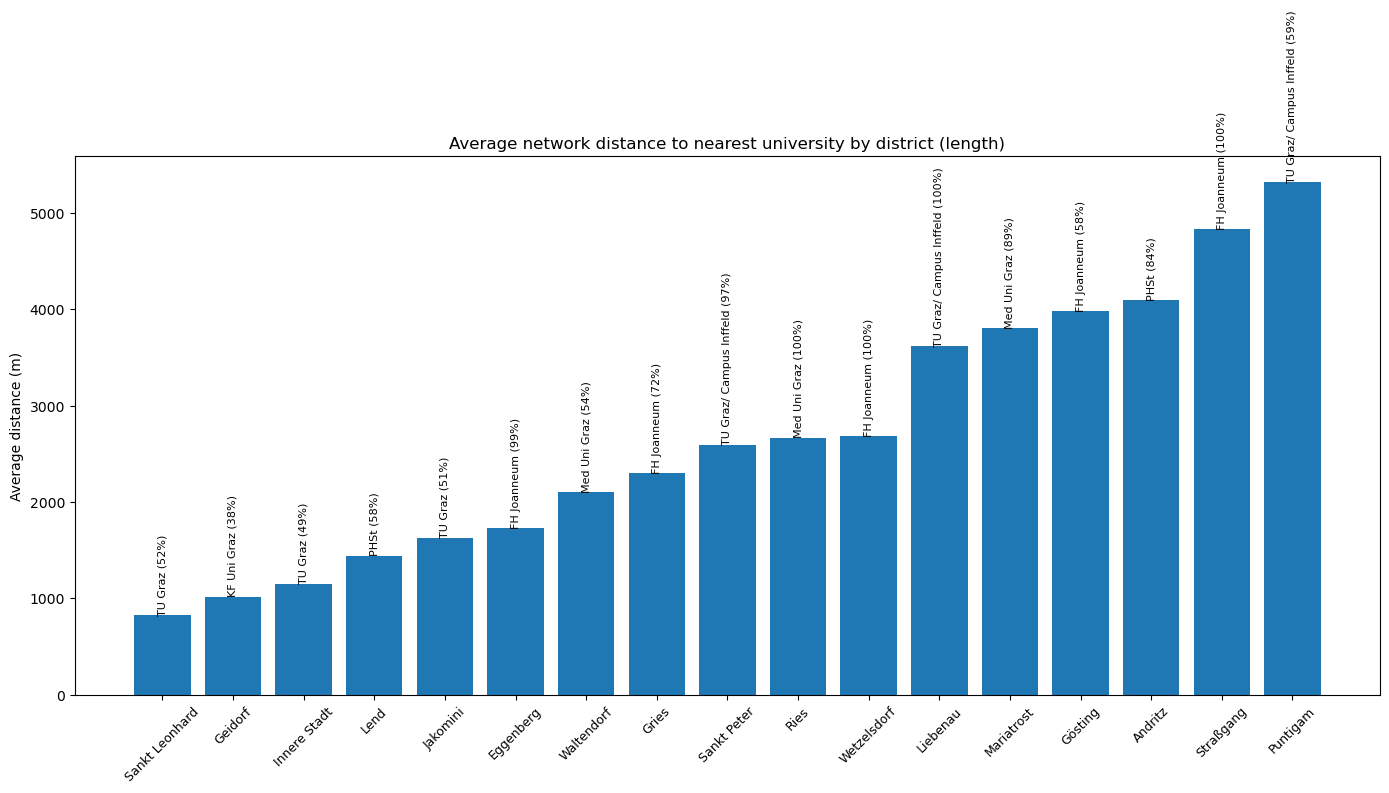

In [59]:
# Prefix -> label (works with truncated strings)
prefix_map = {
    "Universitätsplatz": "KF Uni Graz",
    "Rechbauerstraße 12": "TU Graz",
    "Neue Stiftingtal": "Med Uni Graz",
    "Leonhardstraße 15": "KUG",
    "Körblergasse 126": "Campus02",
    "Alte Poststraße 14": "FH Joanneum",
    "Hasnerplatz 12": "PHSt",
    "Inffeldgasse 25": "TU Graz/ Campus Inffeld",
}

def map_by_prefix(s):
    if s is None or (isinstance(s, float) and pd.isna(s)):
        return s
    s = str(s).strip()
    for pref, lab in prefix_map.items():
        if s.startswith(pref):
            return lab
    return s  # fallback

# Build routes table
rows = []
for dname, stats in district_results.items():
    for r in stats.get("routes", []):
        rows.append({"District": dname, "uni_raw": r.get("uni_shortname")})
routes_df = pd.DataFrame(rows)

# Top-1 nearest uni per district + share
top_uni = (
    routes_df.dropna(subset=["uni_raw"])
             .groupby(["District", "uni_raw"])
             .size()
             .reset_index(name="n")
             .sort_values(["District", "n"], ascending=[True, False])
)

top1 = top_uni.groupby("District").head(1).copy()
totals = routes_df.groupby("District").size().reset_index(name="n_total")
top1 = top1.merge(totals, on="District", how="left")
top1["share_pct"] = (top1["n"] / top1["n_total"] * 100).round(1)

top1["uni_label"] = top1["uni_raw"].apply(map_by_prefix)

# Merge into summary_df and plot
plot_df = summary_df.dropna(subset=["Avg Cost"]).copy()
plot_df = plot_df.merge(top1[["District", "uni_label", "share_pct"]], on="District", how="left")
plot_df = plot_df.sort_values("Avg Cost", ascending=True)

fig, ax = plt.subplots(figsize=(14, 8))
bars = ax.bar(plot_df["District"], plot_df["Avg Cost"])

ax.set_title("Average network distance to nearest university by district (length)")
ax.set_ylabel("Average distance (m)")
ax.tick_params(axis="x", rotation=45, labelsize=9)

for rect, uni, share in zip(bars, plot_df["uni_label"], plot_df["share_pct"]):
    label = "" if pd.isna(uni) else f"{uni} ({share:.0f}%)"
    ax.text(
        rect.get_x() + rect.get_width()/2,
        rect.get_height(),
        label,
        ha="center",
        va="bottom",
        rotation=90,
        fontsize=8
    )

plt.tight_layout()
plt.show()


## Bar Chart weighted

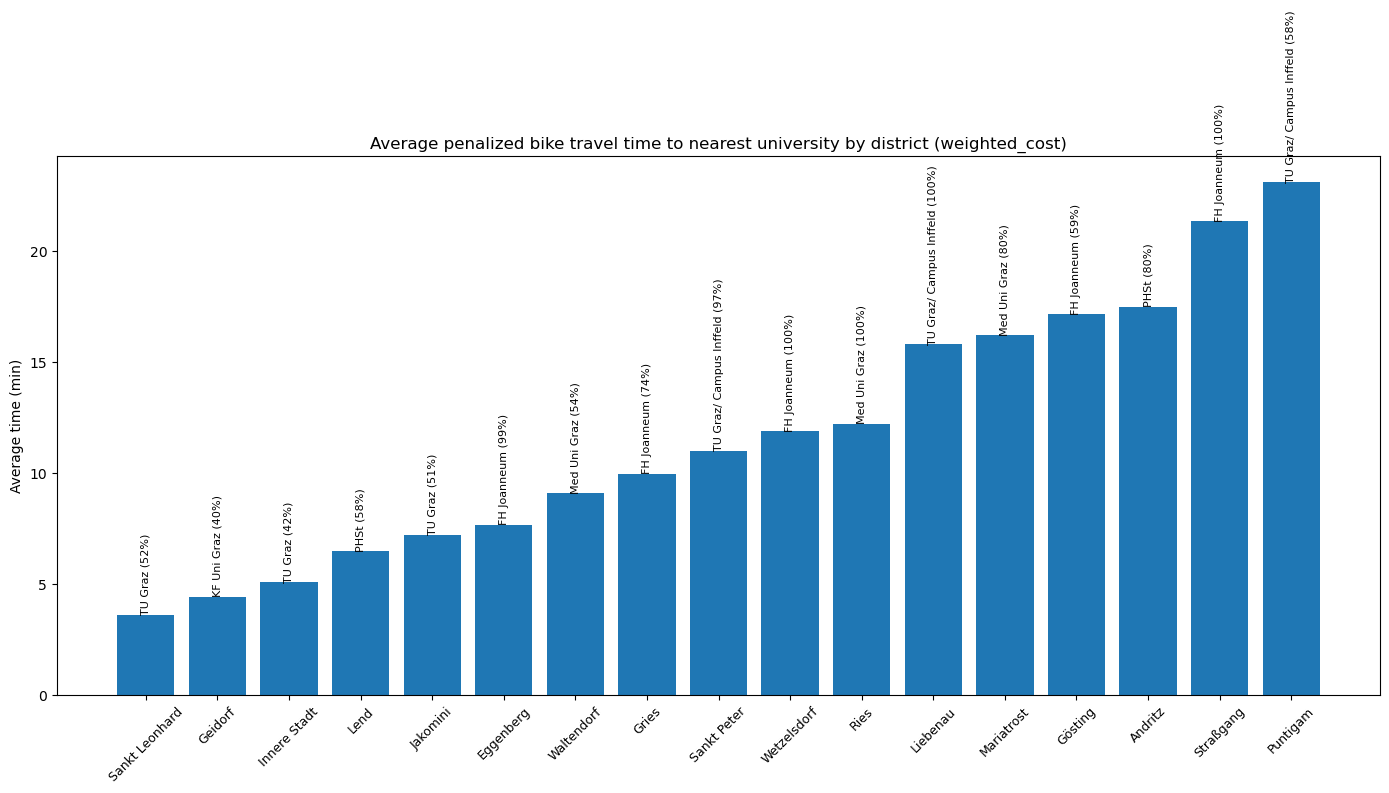

,District,attempted_nodes,routed_nodes,success_rate,avg_cost_s,min_cost_s,max_cost_s,weight_type,routes,avg_cost_min,min_cost_min,max_cost_min,uni_label,share_pct
0,Sankt Leonhard,828,824,0.995169,215.963769,0.000000,447.387991,weighted_cost,"[{'origin_node': 20832657, 'uni_node': 1245921...",3.599396,0.000000,7.456467,TU Graz,52.1
1,Geidorf,1537,1534,0.998048,264.802847,0.000000,605.735495,weighted_cost,"[{'origin_node': 921579363, 'uni_node': 773222...",4.413381,0.000000,10.095592,KF Uni Graz,40.2
2,Innere Stadt,583,550,0.943396,303.277674,111.114023,540.972002,weighted_cost,"[{'origin_node': 20911117, 'uni_node': 4113732...",5.054628,1.851900,9.016200,TU Graz,42.4
3,Lend,1128,1125,0.997340,388.678590,34.317557,743.089829,weighted_cost,"[{'origin_node': 20832681, 'uni_node': 1338451...",6.477977,0.571959,12.384830,PHSt,57.6
4,Jakomini,1224,1216,0.993464,432.714659,0.000000,809.435288,weighted_cost,"[{'origin_node': 331467889, 'uni_node': 124592...",7.211911,0.000000,13.490588,TU Graz,51.4


In [ ]:

# ------------------------------------------------------------
# District routing (weighted_cost) + summary + labeled bar chart
# weighted_cost is in seconds -> we plot minutes
# ------------------------------------------------------------

weight_type = "weighted_cost"

district_results_w = {}

for district_name, nodes_in_district in nodes_by_district.items():
    attempted_nodes = len(nodes_in_district)
    routed_nodes = 0
    costs_s = []
    routes_data = []

    for origin_node in nodes_in_district:
        res = find_nearest_uni_fast(
            origin_node, all_uni_node_ids, uni_distance_maps, weight_type=weight_type
        )
        if res is None:
            continue

        routed_nodes += 1
        cost_s = float(res["cost"])  # seconds
        uni_node = res["uni_node"]
        uni_short = uni_node_to_short.get(uni_node, str(uni_node))

        costs_s.append(cost_s)
        routes_data.append({
            "origin_node": origin_node,
            "uni_node": uni_node,
            "uni_shortname": uni_short,
            "cost_s": cost_s,
            "district": district_name,
        })

    district_results_w[district_name] = {
        "attempted_nodes": attempted_nodes,
        "routed_nodes": routed_nodes,
        "success_rate": (routed_nodes / attempted_nodes) if attempted_nodes > 0 else np.nan,
        "avg_cost_s": float(np.mean(costs_s)) if routed_nodes > 0 else np.nan,
        "min_cost_s": float(np.min(costs_s)) if routed_nodes > 0 else np.nan,
        "max_cost_s": float(np.max(costs_s)) if routed_nodes > 0 else np.nan,
        "weight_type": weight_type,
        "routes": routes_data,
    }

summary_w = (
    pd.DataFrame.from_dict(district_results_w, orient="index")
      .reset_index()
      .rename(columns={"index": "District"})
)

# seconds -> minutes (more interpretable)
summary_w["avg_cost_min"] = summary_w["avg_cost_s"] / 60.0
summary_w["min_cost_min"] = summary_w["min_cost_s"] / 60.0
summary_w["max_cost_min"] = summary_w["max_cost_s"] / 60.0

summary_w = summary_w.sort_values("avg_cost_min", ascending=True).reset_index(drop=True)

# ------------------------------------------------------------
# Top-1 nearest university per district (mode) + share (%)
# ------------------------------------------------------------
rows = []
for dname, stats in district_results_w.items():
    for r in stats.get("routes", []):
        rows.append({"District": dname, "uni_raw": r.get("uni_shortname")})

routes_df = pd.DataFrame(rows)

top_uni = (
    routes_df.dropna(subset=["uni_raw"])
             .groupby(["District", "uni_raw"])
             .size()
             .reset_index(name="n")
             .sort_values(["District", "n"], ascending=[True, False])
)

top1 = top_uni.groupby("District").head(1).copy()
totals = routes_df.groupby("District").size().reset_index(name="n_total")
top1 = top1.merge(totals, on="District", how="left")
top1["share_pct"] = (top1["n"] / top1["n_total"] * 100).round(1)

# If your uni_shortname values are still truncated/addresses, map them to nice labels via prefix
prefix_map = {
    "Universitätsplatz": "KF Uni Graz",
    "Rechbauerstraße 12": "TU Graz",
    "Neue Stiftingtal": "Med Uni Graz",
    "Leonhardstraße 15": "KUG",
    "Körblergasse 126": "Campus02",
    "Alte Poststraße 14": "FH Joanneum",
    "Alte Poststraße 149": "FH Joanneum",
    "Hasnerplatz 12": "PHSt",
    "Inffeldgasse 25": "TU Graz/ Campus Inffeld",
}

def map_by_prefix(s):
    if s is None or (isinstance(s, float) and np.isnan(s)):
        return s
    s = str(s).strip()
    for pref, lab in prefix_map.items():
        if s.startswith(pref):
            return lab
    return s

top1["uni_label"] = top1["uni_raw"].apply(map_by_prefix)

# merge labels into summary
plot_df_w = summary_w.merge(top1[["District", "uni_label", "share_pct"]], on="District", how="left")
plot_df_w = plot_df_w.sort_values("avg_cost_min", ascending=True).reset_index(drop=True)

# ------------------------------------------------------------
# Bar chart (minutes)
# ------------------------------------------------------------
fig, ax = plt.subplots(figsize=(14, 8))
bars = ax.bar(plot_df_w["District"], plot_df_w["avg_cost_min"])

ax.set_title("Average penalized bike travel time to nearest university by district (weighted_cost)")
ax.set_ylabel("Average time (min)")
ax.tick_params(axis="x", rotation=45, labelsize=9)

for rect, uni, share in zip(bars, plot_df_w["uni_label"], plot_df_w["share_pct"]):
    label = "" if pd.isna(uni) else f"{uni} ({share:.0f}%)"
    ax.text(
        rect.get_x() + rect.get_width() / 2,
        rect.get_height(),
        label,
        ha="center",
        va="bottom",
        rotation=90,
        fontsize=8
    )

plt.tight_layout()
plt.show()

plot_df_w.head()

# Kepler Maps

In [ ]:
def add_percentile_clip(gdf, col, q_low=2, q_high=98, new_col=None):
    vals = gdf[col].to_numpy()
    vals = vals[np.isfinite(vals)]
    if len(vals) == 0:
        raise ValueError(f"No finite values in column '{col}'")

    vmin, vmax = np.percentile(vals, [q_low, q_high])
    if new_col is None:
        new_col = f"{col}_clip_{q_low}_{q_high}"

    gdf[new_col] = np.clip(gdf[col].astype(float), vmin, vmax)
    return new_col, float(vmin), float(vmax)

metric = "min_per_km"

gdf_grid_k = gdf_grid_with_data.copy()
metric_clip, vmin, vmax = add_percentile_clip(gdf_grid_k, metric, 2, 98)

print(f"Using metric '{metric}' with clipped column '{metric_clip}'")

gdf_unis_k = graz_unis_proj.copy()

if "short_name" not in gdf_unis_k.columns:
    if "name" in gdf_unis_k.columns:
        gdf_unis_k["short_name"] = gdf_unis_k["name"].astype(str).str.slice(0, 18)
    else:
        gdf_unis_k["short_name"] = [f"UNI_{i+1}" for i in range(len(gdf_unis_k))]


gdf_grid_k = gdf_grid_k.to_crs(epsg=4326)
gdf_unis_k = gdf_unis_k.to_crs(epsg=4326)

gdf_unis_k["longitude"] = gdf_unis_k.geometry.x
gdf_unis_k["latitude"]  = gdf_unis_k.geometry.y

df_unis_k = gdf_unis_k[["short_name", "name", "latitude", "longitude"]].copy()
df_unis_k = df_unis_k.dropna(subset=["latitude", "longitude"])

config_grid = {
  "version": "v1",
  "config": {
    "mapState": {
        "latitude": 47.0707,
        "longitude": 15.4395,
        "zoom": 11.5,
        "pitch": 0,
        "bearing": 0
    },
    "visState": {
      "layers": [
        {
          "id": "grid",
          "type": "geojson",
          "config": {
            "dataId": "grid",
            "label": "Grid accessibility (min_per_km)",
            "isVisible": True,
            "columns": {"geojson": "geometry"},
            "visConfig": {
              "opacity": 0.8,
              "strokeOpacity": 0.2,
              "thickness": 0.2
            }
          },
          "visualChannels": {
            "colorField": {"name": metric_clip, "type": "real"},
            "colorScale": "quantile"
          }
        },
        {
          "id": "unis",
          "type": "point",
          "config": {
            "dataId": "unis",
            "label": "Universities",
            "isVisible": True,
            "columns": {"lat": "latitude", "lng": "longitude"},
            "visConfig": {
              "radius": 16,      
              "opacity": 0.95
            }
          }
        }
      ],
      "interactionConfig": {
        "tooltip": {
          "enabled": True,
          "fieldsToShow": {
            "grid": [metric, metric_clip],
            "unis": ["short_name", "name"]
          }
        }
      }
    }
  }
}


# save
out_dir = "maps"
os.makedirs(out_dir, exist_ok=True)

m = KeplerGl(height=700, config=config_grid)
m.add_data(data=gdf_grid_k, name="grid")
m.add_data(data=df_unis_k, name="unis") 

out_file = os.path.join(out_dir, "kepler_graz_grid_min_per_km.html")
m.save_to_html(file_name=out_file, read_only=False)

print("Saved:", out_file)


Using metric 'min_per_km' with clipped column 'min_per_km_clip_2_98'
User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
Map saved to maps\kepler_graz_grid_min_per_km.html!
Saved: maps\kepler_graz_grid_min_per_km.html


In [ ]:
required_cols = {"District", "Avg Cost", "uni_label", "share_pct"}
missing = required_cols - set(plot_df.columns)
if missing:
    raise KeyError(f"plot_df is missing columns: {missing}. Available: {list(plot_df.columns)}")

district_map_gdf = (
    valid_districts[["district_name", "geometry"]]
    .rename(columns={"district_name": "District"})
    .merge(plot_df[["District", "Avg Cost", "uni_label", "share_pct"]], on="District", how="left")
)

print("Rows:", len(district_map_gdf))
print(district_map_gdf[["District", "Avg Cost", "uni_label", "share_pct"]].head())


gdf_dist_k = district_map_gdf.copy().to_crs(epsg=4326)

gdf_unis_k = graz_unis_proj.copy()
if "short_name" not in gdf_unis_k.columns:
    if "name" in gdf_unis_k.columns:
        gdf_unis_k["short_name"] = gdf_unis_k["name"].astype(str).str.slice(0, 18)
    else:
        gdf_unis_k["short_name"] = [f"UNI_{i+1}" for i in range(len(gdf_unis_k))]

gdf_unis_k = gdf_unis_k.to_crs(epsg=4326)
gdf_unis_k["longitude"] = gdf_unis_k.geometry.x
gdf_unis_k["latitude"]  = gdf_unis_k.geometry.y

df_unis_k = gdf_unis_k[["short_name", "name", "latitude", "longitude"]].copy()
df_unis_k = df_unis_k.dropna(subset=["latitude", "longitude"])

district_metric = "Avg Cost"  

config_dist = {
  "version": "v1",
  "config": {
    "mapState": {
        "latitude": 47.0707,
        "longitude": 15.4395,
        "zoom": 11.5,
        "pitch": 0,
        "bearing": 0
    },
    "visState": {
      "layers": [
        {
          "id": "districts",
          "type": "geojson",
          "config": {
            "dataId": "districts",
            "label": "District accessibility (Avg Cost)",
            "isVisible": True,
            "columns": {"geojson": "geometry"},
            "visConfig": {
              "opacity": 0.8,
              "strokeOpacity": 0.3,
              "thickness": 0.3
            }
          },
          "visualChannels": {
            "colorField": {"name": district_metric, "type": "real"},
            "colorScale": "quantile"
          }
        },
        {
          "id": "unis",
          "type": "point",
          "config": {
            "dataId": "unis",
            "label": "Universities",
            "isVisible": True,
            "columns": {"lat": "latitude", "lng": "longitude"},
            "visConfig": {
              "radius": 16,
              "opacity": 0.95
            }
          }
        }
      ],
      "interactionConfig": {
        "tooltip": {
          "enabled": True,
          "fieldsToShow": {
            "districts": ["District", district_metric, "uni_label", "share_pct"],
            "unis": ["short_name", "name"]
          }
        }
      }
    }
  }
}


# save
out_dir = "maps"
os.makedirs(out_dir, exist_ok=True)

m2 = KeplerGl(height=700, config=config_dist)
m2.add_data(data=gdf_dist_k, name="districts")
m2.add_data(data=df_unis_k, name="unis")  

out_file2 = os.path.join(out_dir, "kepler_graz_districts_weighted.html")
m2.save_to_html(file_name=out_file2, read_only=False)

print("Saved:", out_file2)


Rows: 17
         District  Avg Cost                uni_label  share_pct
0    Innere Stadt   1153.11                  TU Graz       48.9
1        Liebenau   3617.56  TU Graz/ Campus Inffeld      100.0
2  Sankt Leonhard    821.84                  TU Graz       52.1
3         Geidorf   1016.28              KF Uni Graz       37.7
4            Lend   1443.76                     PHSt       57.5
User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
Map saved to maps\kepler_graz_districts_weighted.html!
Saved: maps\kepler_graz_districts_weighted.html


In [ ]:
def add_percentile_clip(gdf, col, q_low=2, q_high=98, new_col=None):
    vals = gdf[col].to_numpy()
    vals = vals[np.isfinite(vals)]
    if len(vals) == 0:
        raise ValueError(f"No finite values in column '{col}'")
    vmin, vmax = np.percentile(vals, [q_low, q_high])
    if new_col is None:
        new_col = f"{col}_clip_{q_low}_{q_high}"
    gdf[new_col] = np.clip(gdf[col].astype(float), vmin, vmax)
    return new_col, float(vmin), float(vmax)

# Prepare grid data
gdf_grid_k = gdf_grid_with_data.copy().to_crs(epsg=4326)

# Prepare universities data
gdf_unis_k = graz_unis_proj.copy()
if "short_name" not in gdf_unis_k.columns:
    if "name" in gdf_unis_k.columns:
        gdf_unis_k["short_name"] = gdf_unis_k["name"].astype(str).str.slice(0, 18)
    else:
        gdf_unis_k["short_name"] = [f"UNI_{i+1}" for i in range(len(gdf_unis_k))]

gdf_unis_k = gdf_unis_k.to_crs(epsg=4326)
gdf_unis_k["longitude"] = gdf_unis_k.geometry.x
gdf_unis_k["latitude"]  = gdf_unis_k.geometry.y

df_unis_k = gdf_unis_k[["short_name", "name", "latitude", "longitude"]].copy()
df_unis_k = df_unis_k.dropna(subset=["latitude", "longitude"])

# Calculate delta
if "avg_weighted_time_min" not in gdf_grid_k.columns:
    gdf_grid_k["avg_weighted_time_min"] = gdf_grid_k["avg_weighted_s"] / 60.0

if "distance_km" not in gdf_grid_k.columns:
    gdf_grid_k["distance_km"] = gdf_grid_k["avg_distance_m"] / 1000.0

FLAT_CYCLING_SPEED_KMH = 15.0
gdf_grid_k["theoretical_time_min"] = (gdf_grid_k["distance_km"] / FLAT_CYCLING_SPEED_KMH) * 60.0
gdf_grid_k["delta_time_min"] = gdf_grid_k["avg_weighted_time_min"] - gdf_grid_k["theoretical_time_min"]

print(f"Delta range: {gdf_grid_k['delta_time_min'].min():.2f} to {gdf_grid_k['delta_time_min'].max():.2f} minutes")

# Create clipped column
delta_clip, vmin, vmax = add_percentile_clip(gdf_grid_k, "delta_time_min", 2, 98)

print(f"Clipped delta range: {vmin:.2f} - {vmax:.2f} minutes")

# Kepler
config_delta = {
  "version": "v1",
  "config": {
    "mapState": {
        "latitude": 47.0707,
        "longitude": 15.4395,
        "zoom": 11.5,
        "pitch": 0,
        "bearing": 0
    },
    "visState": {
      "layers": [
        {
          "id": "delta_grid",
          "type": "geojson",
          "config": {
            "dataId": "grid",
            "label": "Time Penalty: Infrastructure vs Flat Distance",
            "isVisible": True,
            "columns": {"geojson": "geometry"},
            "visConfig": {
              "opacity": 0.85,
              "strokeOpacity": 0.15,
              "thickness": 0.2
            }
          },
          "visualChannels": {
            "colorField": {"name": delta_clip, "type": "real"},
            "colorScale": "quantile"
          }
        },
        {
          "id": "unis",
          "type": "point",
          "config": {
            "dataId": "unis",
            "label": "Universities",
            "isVisible": True,
            "columns": {"lat": "latitude", "lng": "longitude"},
            "visConfig": {
              "radius": 18,
              "opacity": 0.95,
              "color": [255, 0, 0]
            }
          }
        }
      ],
      "interactionConfig": {
        "tooltip": {
          "enabled": True,
          "fieldsToShow": {
            "grid": [
              "avg_distance_m", 
              "avg_weighted_time_min", 
              "theoretical_time_min",
              "delta_time_min",
              "min_per_km"
            ],
            "unis": ["short_name", "name"]
          }
        }
      }
    }
  }
}

# Save 
out_dir = "maps"
os.makedirs(out_dir, exist_ok=True)

m_delta = KeplerGl(height=700, config=config_delta)
m_delta.add_data(data=gdf_grid_k, name="grid")
m_delta.add_data(data=df_unis_k, name="unis")

out_file = os.path.join(out_dir, "kepler_graz_grid_delta_time_penalty.html")
m_delta.save_to_html(file_name=out_file, read_only=False)

print(f"Saved: {out_file}")

Delta range: 0.00 to 8.20 minutes
Clipped delta range: 0.04 - 3.33 minutes
User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
Map saved to maps\kepler_graz_grid_delta_time_penalty.html!
Saved: maps\kepler_graz_grid_delta_time_penalty.html
